# Checking the SEO Test Setup

I.e. checking that the right urls are set up, without going too crazy on testing everything.

In brief:

* Focus on the articles
* Check the test urls are accessible and show v2
* If AMP is enabled, test that control urls show v1 AMP and test urls show v2
* Check the canonicals
* Check the breadcrumbs
* That cloudflare looks to be working


Out of scope:

* That an AMP page is valid AMP (we have a separate test suite for this)
* Being robust to html that isn't what's expected during blog v2 launch!
* Testing non-article pages (home page, category page etc)

In [2]:
import requests
from datetime import datetime
from bs4 import BeautifulSoup
import csv
import json
import urllib
import json
import time
import matplotlib.pyplot as plt
from random import random, randint
import numpy as np

## Settings


In [57]:
country_to_test = "id"
test_staging = True

test_urls_csv_filepath = {  # These originally come from https://docs.google.com/spreadsheets/d/1UdrncwVdObaA6d0lnvbAQCHBpQMzEhWPz5OTR9Syobo/edit#gid=0
    "id":"./SEO Test Urls/id_seo_test_urls.csv",
    "tw":"./SEO Test Urls/tw_seo_test_urls.csv",
    "sg": None,
    "hk": None,
}

production_staging_urls = {
    "id": ["https://www.moneysmart.id", "https://www.msiddev.com"],
    "tw":["https://www.moneysmart.tw", "https://www.mstwdev.com"],
    "sg": ["https://blog.moneysmart.sg","https://blog.mssgdev.com"],
    "hk":["https://www.moneysmart.hk", "https://blog.mshkdev.com"],
}

def get_site_canonical_url():
    
    return production_staging_urls[country_to_test][(1 if test_staging else 0)]

post_sitemaps = { #yes, we could load some more dynamically but it saves some coding
    "id": ["https://www.moneysmart.id/post-sitemap%i.xml"%i for i in range(1,13)],
    "tw": ["https://www.moneysmart.tw/post-sitemap.xml"],
    "sg": ["https://blog.moneysmart.sg/post-sitemap%i.xml"%i for i in range(1,5)],
    "hk": ["https://blog.moneysmart.hk/post-sitemap%i.xml"%i for i in range(1,3)],
    
    #Aside, there seems to be public pages for the ads in the sitemap :( 
    
}


#These passwords aren't sensitive, they're just there to block search engine.
v1_staging_passwords = {
    "id":["admin", "moneysmart"],
    "tw":["admin", "Bubbl3"],
    "sg":["admin", "duri@n"],
    "hk":["admin", "yu3ch@"],
}

v2_staging_passwords = {
    "id":["admin", "moneysmart"],
    "tw":["admin", "moneysmart"],
    "sg":["admin", "moneysmart"],
    "hk":["admin", "moneysmart"],
}


## Test URL Sets

In [50]:
def load_seo_test_urls(country_code):
    filepath = test_urls_csv_filepath[country_code]
    urls = []
    with open(filepath) as f:
        csv_reader = csv.reader(f, delimiter=',')
        for i, row in enumerate(csv_reader):
            if i==0:
                print("Skipping first line of url file: %s"%row)
                continue
            urls.append(row[0].strip())

    return urls

seo_test_urls = load_seo_test_urls(country_to_test)

print("Found %i test urls to check for" % len(seo_test_urls))


Skipping first line of url file: ['url']
Found 50 test urls to check for


In [51]:
for a in seo_test_urls:print(a)

https://www.moneysmart.id/klikbca-gini-lho-cara-cepat-daftar-internet-banking-bca/
https://www.moneysmart.id/klikbca-individual-ini-cara-daftar/
https://www.moneysmart.id/daftar-kode-bank-indonesia-terlengkap-lebih-dari-100-bank/
https://www.moneysmart.id/unipin-voucher-game-online/
https://www.moneysmart.id/djp-online-cara-cepat-bayar-pajak-lapor-spt/
https://www.moneysmart.id/harga-emas-hari-ini/
https://www.moneysmart.id/cara-ambil-antrian-online-bpjs-ketenagakerjaan/
https://www.moneysmart.id/vpn-tarumanagara-cara-log-in-klikbca-bisnis-tanpa-aplikasi/
https://www.moneysmart.id/daftar-internet-banking-bni-gak-ribet-kok-gini-cara-cepatnya/
https://www.moneysmart.id/cara-membuat-npwp-online/
https://www.moneysmart.id/daftar-cimb-clicks-gampang-kok/
https://www.moneysmart.id/nomor-call-center-bca-yang-bisa-dihubungi/
https://www.moneysmart.id/surat-lamaran-kerja-dan-cara-serta-contohnya/
https://www.moneysmart.id/bca-mobile-gini-lho-cara-aktifkan-mobile-banking-bca/
https://www.moneysm

That leaves 696 post urls that aren't in the test


## Utility Functions

In [40]:
def get_urls_from_sitemap(sitemap_url, page_cache):
    
    #r = requests.get(sitemap_url)
    #soup = BeautifulSoup(r.text, "html.parser") #html parser does xml fine
    soup = page_cache.get_soup(sitemap_url)
    urls = [element.text for element in soup.findAll('loc')]
    return urls

def get_all_post_urls_from_sitemap(country_code, page_cache):
    # Note that separately I'm loading all the sitemaps, so you could use that instead if you can filter the posts.
    sitemaps = post_sitemaps[country_code]
    all_urls = []
    for i, sitemap in enumerate(sitemaps):
        print("Loading urls from sitemap %i of %i %s" % (i, len(sitemaps), sitemap))
        sitemap_urls = get_urls_from_sitemap(sitemap, page_cache)
        all_urls+=sitemap_urls
    return all_urls



In [38]:
def extract_sub_sitemaps_from_sitemap(sitemap_url, page_cache, recursive = False):
    root_sitemap_soup = page_cache.get_soup(sitemap_url)
    sub_sitemaps = []
    for sitemap_block in root_sitemap_soup.find_all("sitemap"):
        sub_sitemap_url = sitemap_block.loc.text
        sub_sitemaps.append(sub_sitemap_url)
        if recursive:
            next_levels =  extract_sub_sitemaps_from_sitemap(sub_sitemap_url, page_cache, recursive = True)
            sub_sitemaps+=next_levels
    return sub_sitemaps

In [137]:
def is_v2_url(url):
    splits = urllib.parse.urlparse(url)
    if "www3." in splits.netloc or "blog3." in splits.netloc:
        return True
    return False

def is_v1_url(url):
    return not is_v2_url(url)

def make_v2_url(url):
    #>>>
    
    return v2_url
    
def make_v2_staging_url(url):
    # not responsible for auth
    production_root, staging_root = production_staging_urls[country_to_test]
    if production_root not in url:
        raise Exception()
        
    staging_url = url.replace(production_root, staging_root)
    
    return staging_url
    
    
def make_v1_staging_url(url):
    # not responsible for auth
    pass
                                   

def is_amp_page(url, page_cache):
    """
    Very basic test on whether the page is marked in the html tag as AMP
    
       # <html ⚡> or <html amp>
    rab"""
    soup = page_cache.get_soup(url)
    html_tag = soup.find('html')
    html_tag.attrs
    
    if "amp" in html_tag.attrs or "⚡" in html_tag.attrs:
        return True
    return False
    
    
 
    
def is_v2_page(url, page_cache):
    """
    Very basic test if it's a v2 page based on knowledge of it.
    """
    html = page_cache.get_html(url)
    if "nuxt" in html:
        return True
    return False
    
    
def is_v2_amp_page(url, page_cache):
    if is_v2_page(url, page_cache) and is_amp_page(url, page_cache):
        return True
    return False
    
def extract_link_of_type(url, page_cache, type_of_link):
    """
    Generally don't call this directly.
    
    Expects it to be unique in the page / no duplicates
    """
    
    soup = page_cache.get_soup(url)
    links = soup.find_all("link")
    suitable_link_tags = [z for z in links if "rel" in z.attrs and z.attrs["rel"][0].lower()==type_of_link.lower()]
    if len(suitable_link_tags)==0:
        return None
    if len(suitable_link_tags)>1:
        raise Exception()
    
    link_url = suitable_link_tags[0].get("href")
    
    return link_url
    
    
    
    
    
def extract_link_to_amp_version(url, page_cache):
    """
    Returns none if the amp version can't be found
    
    Looking for <link rel="amphtml" href="..."
    
    Returns the url it links to
    """
    amp_url = extract_link_of_type(url, page_cache, "amphtml")
    
    return amp_url

def amp_and_canonical_urls_match(amp_url, canonical_url):
    if amp_url == canonical_url+"?amp": # better would be to do a join using url library
        return True
    return False
    
    

    
    
def extract_canonical_tag(url, page_cache):
    """
    
    Looks for <link rel="canonical" href="....">
    
    This is similar to amphtml
    """
    canonical_url = extract_link_of_type(url, page_cache, "canonical")
    return canonical_url

    
def canonical_tag_is_valid(url, canonical_url):
    """
    Returns bool, error_message
    
    """
    url_components = urllib.parse.urlparse(url)
    canonical_components = urllib.parse.urlparse(canonical_url)
    
    error_message = ""
    
    
    #Canonical uses https
    if canonical_components.scheme != "https":
        error_message += "Canonical does't use https. "
    
    # no query params in canonical
    if canonical_components.query:
        error_message += "Canonical url contains query parameters. "
    
    
    # goes to base url
    expected_root_url = get_site_canonical_url()
    if not canonical_url.startswith(expected_root_url):
        error_message += "Canonical url doesn't appear to point to right site."
    
    
    # url and canonical point to the same article
    if url_components.path != canonical_components.path:
        error_message += "Canonical and url don't point to same url. "
    
    
    return error_message!="", error_message
    
def extract_meta_description(url, page_cache):
    """
    <meta name="description" content="Jika kamu...">
    
    """
    print("getting meta description for %s"%url)
    soup = page_cache.get_soup(url)

    
    meta_tags = soup.find_all("meta")
    meta_tag_name = "description"
    
    suitable_tags = [z for z in meta_tags if "name" in z.attrs and z.attrs["name"].lower()==meta_tag_name.lower()]
    if len(suitable_tags)==0:
        return None
    if len(suitable_tags)>1:
        raise Exception()
    
    #print("suitable tag %s"%suitable_tags[0])
    meta_description = suitable_tags[0].get("content")
    return meta_description
    
    
def extract_ld_json_structured_data(url, page_cache, type_of_structured_data):
    """
    Returns as parsed JSON i.e. should be able to inspect as a dictionary etc.
    """
    
    #Note there's lots of valid ways of doing this, I'm just trying to match the way it's been implemented
    
    soup = page_cache.get_soup(url)
    
    script_tags = soup.find_all("script")
    sd_tags = [z for z in script_tags if "type" in z.attrs and z.attrs["type"]=="application/ld+json"]
    #print(sd_tags)
    json_structured_datas = [json.loads(z.contents[0]) for z in sd_tags]
    structured_datas_of_type = [z for z in json_structured_datas if z["@type"]==type_of_structured_data]
    if len(structured_datas_of_type) > 1:
        raise Exception()
    if len(structured_datas_of_type) == 0:
        raise Exception() # just for debugging
        return None
    return structured_datas_of_type[0]
    
def extract_blogposting_structured_data(url, page_cache):
    sd = extract_ld_json_structured_data(url, page_cache, "BlogPosting")
    return sd


def check_blogposting_structured_data_looks_sensible(url, page_cache):
    """
    returns [bool, error_message]
    """
    error_message = ""
    sd = extract_blogposting_structured_data(url, page_cache)
    
    
    expected_top_level_keys = ["@type", 
                               "headline", 
                               "datePublished", 
                               "dateModified",
                               "mainEntityOfPage",
                               "image",
                               "author",
                               "publisher",
                              ]
    missing_top_level_keys = [z for z in expected_top_level_keys if z not in sd]
    if len(missing_top_level_keys)>0:
        error_message += "BlogPosting was missing the following keys: %s .  "%missing_top_level_keys
    
    page_meta_description = extract_meta_description(url, page_cache)
    bp_description = sd["description"]
    if bp_description != page_meta_description:
        error_message+="Page meta description doesn't match blogposting description.  \n %s \n vs \n %s"%(page_meta_description,bp_description)
        
    #TODO: check headline
    
    logo_details = sd["publisher"]["logo"]
    logo_width = int(logo_details["width"])
    logo_height = int(logo_details["height"])
    
    expected_logo_width = 447
    expected_logo_height = 60
    
    if logo_width != expected_logo_width or logo_height!=expected_logo_height:
        error_message+="Logo size in structured data was (%i, %i) not (%i, %i).  "%(logo_width, logo_height, expected_logo_width, expected_logo_height)
    
    bp_id = sd["mainEntityOfPage"]["@id"]
    canonical_url = extract_canonical_tag(url, page_cache)
    if bp_id != canonical_url:
        error_message+="Expected the ID of the blogposting to be the canonical tag, but got %s.  "% bp_id
        
    return (len(error_message)==0, error_message)
        
    
    
def extract_breadcrumbs_as_list(url, page_cache):
    """
    Returns [[name, url]]
    
        {
    "@context": "https://schema.org",
    "@type": "BreadcrumbList",
      "itemListElement": [{
        "@type": "ListItem",
        "position": 1,
        "name": "Books",
        "item": "https://example.com/books"
      },
      ...
      }
    
    """
    sd = extract_ld_json_structured_data(url, page_cache, "BreadcrumbList")
    
    breadcrumbs = [[z["position"], z["item"]["name"], z["item"]["@id"]] \
                   for z in sd["itemListElement"]\
                      if z["@type"]=="ListItem"
                  ]
    breadcrumbs.sort(key=lambda x: x[0]) #sort by position
    
    
    return [z[1:] for z in breadcrumbs]


def check_breadcrumbs_are_sensible(url, page_cache):
    """
    Return (is_ok, error_message)
    """
    # TODO: ideally would add some more checks on the validity of the structured data, but they can be done
    # fairly easily with external tools.
    
    error_message = ""
    breadcrumbs = extract_breadcrumbs_as_list(url, page_cache)
    breadcrumb_names = [z[0] for z in breadcrumbs]
    breadcrumb_urls = [z[1] for z in breadcrumbs]
    
    expected_url_root = get_site_canonical_url()
    
    
    breadcrumbs_not_starting_with_root = [z for z in breadcrumb_urls if not z.startswith(expected_url_root)]
    
    if len(breadcrumbs_not_starting_with_root):
        error_message+= "Breadcrumbs didn't all start with the right url base (%s) %s . "%(expected_url_root, breadcrumbs_not_starting_with_root)
    
    if breadcrumb_urls[0].strip("/")!=expected_url_root:
        error_message += "Expected 1st breadcrumb to be homepage %s, but got %s.  "%(expected_url_root, breadcrumb_urls[0])
    
    num_unique_urls =  len(set(breadcrumb_urls))
    if num_unique_urls != len(breadcrumb_urls):
        error_message += "Breadcrumbs weren't unique.  Got %s .  "%breadcrumb_urls
    
    #Check there's at least 3 (homepage, category, article)
    
    if len(breadcrumbs)<3:
        error_message+="Expected at least homepage, category and article in breadcrumbs, but got %s.   "%breadcrumbs
    
    return (len(error_message)==0, error_message)
    
    
    



In [9]:
class PageCache(object):
    """
    This is an abstraction for getting a url, which understands
    translation between staging and production, authentication etc
    and uses a cache to allow efficient repeat requests.
    (and whether that cache is in memory, or not is academic)
    
    It also includes throttling.
    
    The result might be a redirect to say www3 or whatever.
    
    NB this does currently rely on some globals
    """
    
    def __init__(self):
        self._page_cache_dict = {} #url:[page_html, load_time, cloudflare_in_headers, cloudflare_hit, url_after_redirect]
        self._soup_cache_dict = {} #url: beautifulsoup
        self._page_load_time_dict = {} # a log of how long it takes to load the pages in seconds
        self.last_page_respone_time  = datetime.now()
        self.min_seconds_between_server_requests = 0.5 #currently after request completion, rather than start
    
    def get_html(self, url, refresh_cache = False):
        """
        This gets the url, but only requests it if it isn't in the page cache currently
        """
        if refresh_cache or url not in self._page_cache_dict:
            seconds_since_last_request = (datetime.now() - self.last_page_respone_time).total_seconds()
            wait_time = self.min_seconds_between_server_requests - seconds_since_last_request
            if wait_time>0:
                print("Throttling request for %.2f seconds"%wait_time)
                time.sleep(wait_time)
            
            self._download_url_and_cache(url) # this also does things like check caching and do timing.
            
        html = self._page_cache_dict[url][0]
        
        self.last_page_request_time = datetime.now()
        
        return html
        
    def get_soup(self, url):
        """
        Returns the beautifulsoup version of the page for tag extraction
        """
        if url not in self._soup_cache_dict:
            html = self.get_html(url)
            soup = BeautifulSoup(html, "html.parser")
            self._soup_cache_dict[url] = soup

        return self._soup_cache_dict[url]
        

        
    def _download_url_and_cache(self, url):
        user_pass = None
        
        
        if test_staging:
            #Need to deal with basic auth
            # TODO
            if is_v1_url(url):
                user_pass = v1_staging_passwords[country_to_test]
            else:
                user_pass = v2_staging_passwords[country_to_test]
            user_pass = tuple(user_pass) #required to make the requests library happy
        
        r = requests.get(url, auth= user_pass)
        if r.status_code!=200:
            print("WARNING: STATUS CODE %s" % str(r.status_code))
        if r.status_code == 401:
            
            print("Got a 401 on %s with credentials %s" % (url, user_pass))
            if test_staging:
                print("Going to try again with other creds as likely redirect with different creds.")
                if not is_v1_url(url): # flipping counter-intuitively
                    user_pass = v1_staging_passwords[country_to_test]
                else:
                    user_pass = v2_staging_passwords[country_to_test]
                r = requests.get(url, auth=tuple(user_pass))
                if r.status_code == "401":
                    print("failed with other auth")
                    raise Exception()
            else:
                raise Exception()
        
        r.raise_for_status() #Throw an exception if get e.g. a 404.
        
        load_time = r.elapsed.total_seconds()
        text = r.text
        headers = r.headers
        
        # Look at headers to judge if caching on the html is working
        is_cdn_caching = False
        is_cdn_cache_hit = False
        if "Server" in headers:
            if headers["Server"]=="cloudflare":
                is_cdn_caching = True
                if headers["cf-cache-status"]=="HIT":
                    is_cdn_cache_hit = True
            

        url_after_redirect = r.url
        #"cf-cache-status" "HIT"  /"EXPIRED"
        #"server:cloudflare"
        
        self._page_cache_dict[url] = text, load_time, is_cdn_caching, is_cdn_cache_hit, url_after_redirect

In [10]:
page_cache = PageCache()

In [11]:
soup = page_cache.get_soup("https://www3.moneysmart.id")

In [12]:
soup.html.attrs

{'lang': 'id-ID', 'prefix': 'og: http://ogp.me/ns#'}

In [13]:
urllib.parse.urlparse("https://www3.moneysmart.id/my_cat/my_article?amp")

ParseResult(scheme='https', netloc='www3.moneysmart.id', path='/my_cat/my_article', params='', query='amp', fragment='')

In [14]:
r = requests.get("https://www3.moneysmart.id/tas-hermes-mahal-ini-sebabnya/?forceTest=test")
r_amp = requests.get("https://www3.moneysmart.id/tas-hermes-mahal-ini-sebabnya/?amp")

In [15]:
r.status_code

200

In [16]:
r.text[:100]

'<!doctype html>\n<html data-n-head-ssr lang="id-ID" data-n-head="lang">\n<head data-n-head="">\n<title '

In [86]:
extract_blogposting_structured_data("https://www.moneysmart.id/ayah-nadiem-makarim", page_cache)

[<script type="application/ld+json">{"@context":"https:\/\/schema.org","@type":"BreadcrumbList","itemListElement":[{"@type":"ListItem","position":1,"item":{"@id":"https:\/\/www.moneysmart.id\/","name":"Home"}},{"@type":"ListItem","position":2,"item":{"@id":"https:\/\/www.moneysmart.id\/category\/earn-money\/","name":"Earn Money"}},{"@type":"ListItem","position":3,"item":{"@id":"https:\/\/www.moneysmart.id\/category\/earn-money\/inspirasi\/","name":"Inspirasi"}},{"@type":"ListItem","position":4,"item":{"@id":"https:\/\/www.moneysmart.id\/ayah-nadiem-makarim\/","name":"Nadiem Makarim Bakal Jadi Menteri, Ini Fakta Sang Ayah yang Jarang Orang Tau"}}]}</script>, <script type="application/ld+json">{"@context":"http:\/\/schema.org","@type":"BlogPosting","mainEntityOfPage":{"@type":"WebPage","@id":"https:\/\/www.moneysmart.id\/ayah-nadiem-makarim\/"},"headline":"Nadiem Makarim Bakal Jadi Menteri, Ini Fakta Sang Ayah yang Jarang Orang Tau","image":{"@type":"ImageObject","url":"https:\/\/cdn.mon

{'@context': 'http://schema.org',
 '@type': 'BlogPosting',
 'mainEntityOfPage': {'@type': 'WebPage',
  '@id': 'https://www.moneysmart.id/ayah-nadiem-makarim/'},
 'headline': 'Nadiem Makarim Bakal Jadi Menteri, Ini Fakta Sang Ayah yang Jarang Orang Tau',
 'image': {'@type': 'ImageObject',
  'url': 'https://cdn.moneysmart.id/wp-content/uploads/2019/10/22113627/nono-makarim-wp.jpg',
  'height': 1000,
  'width': 710},
 'datePublished': '2019-10-22T05:00:57',
 'dateModified': '2019-10-22T06:20:22',
 'author': {'@type': 'Person', 'name': 'Aulia Akbar'},
 'publisher': {'@type': 'Organization',
  'name': 'MoneySmart Indonesia',
  'logo': {'@type': 'ImageObject',
   'url': 'https://cdn.moneysmart.id/wp-content/uploads/2019/08/22155126/logo-moneysmart-447x60.png',
   'width': 447,
   'height': 60}},
 'description': 'Ayah Nadiem Makarim, Nono Anwar Makarim, mendadak disebut media karena putranya bakal jadi salah satu Menteri RI. Yuk kenalan lebih dekat dengan Nono'}

# Tests

In [42]:
print("Starting the tests of %s"%country_to_test)

Starting the tests of id


## Check the Homepage still loads!

In [43]:
homepage_url = production_staging_urls[country_to_test][(1 if test_staging else 0)]
print("Checking that the homepage loads %s"%homepage_url)
html = page_cache.get_html(homepage_url)
if len(html)<1000:
    raise Exception()
print("Looks good")

Checking that the homepage loads https://www.moneysmart.id
Looks good


## All Posts from Sitemaps (and test sitemap works!)

In [44]:
all_post_urls = get_all_post_urls_from_sitemap(country_to_test, page_cache)

print("Found %i posts in the sitemap"%len(all_post_urls))


non_seo_test_urls = list(set(all_post_urls) - set(seo_test_urls))
print("That leaves %i post urls that aren't in the test" % len(non_seo_test_urls))

Loading urls from sitemap 0 of 12 https://www.moneysmart.id/post-sitemap1.xml
Loading urls from sitemap 1 of 12 https://www.moneysmart.id/post-sitemap2.xml
Loading urls from sitemap 2 of 12 https://www.moneysmart.id/post-sitemap3.xml
Loading urls from sitemap 3 of 12 https://www.moneysmart.id/post-sitemap4.xml
Loading urls from sitemap 4 of 12 https://www.moneysmart.id/post-sitemap5.xml
Loading urls from sitemap 5 of 12 https://www.moneysmart.id/post-sitemap6.xml
Loading urls from sitemap 6 of 12 https://www.moneysmart.id/post-sitemap7.xml
Loading urls from sitemap 7 of 12 https://www.moneysmart.id/post-sitemap8.xml
Loading urls from sitemap 8 of 12 https://www.moneysmart.id/post-sitemap9.xml
Loading urls from sitemap 9 of 12 https://www.moneysmart.id/post-sitemap10.xml
Loading urls from sitemap 10 of 12 https://www.moneysmart.id/post-sitemap11.xml
Loading urls from sitemap 11 of 12 https://www.moneysmart.id/post-sitemap12.xml
Found 11467 posts in the sitemap
That leaves 11467 post url

### Check all the Sitemaps Load Correctly

In [45]:
sitemap_url = production_staging_urls[country_to_test][(1 if test_staging else 0)] +"/sitemap.xml"
all_sitemaps =  [sitemap_url,] + extract_sub_sitemaps_from_sitemap( sitemap_url, page_cache)

In [46]:
print("Found %i sitemaps in all" % len(all_sitemaps))

Found 26 sitemaps in all


In [48]:
all_urls_in_sitemaps = []

for sitemap in all_sitemaps:
    
    urls_in_sitemap = get_urls_from_sitemap(sitemap, page_cache) # this includes sub-sitemaps
    all_urls_in_sitemaps+= urls_in_sitemap
    print("Sitemap %s had %i urls within it"%(sitemap, len(urls_in_sitemap)))
    if len(urls_in_sitemap)==0:
        raise Exception()
        
num_urls_from_sitemap = len(all_urls_in_sitemap)
num_distinct_urls_from_sitemap = len(set(all_urls_in_sitemap))

if num_urls_from_sitemap != num_distinct_urls_from_sitemap:
    print("ERROR: not all urls in sitemap were distinct")

Sitemap https://www.moneysmart.id/sitemap.xml had 25 urls within it
Sitemap https://www.moneysmart.id/post-sitemap1.xml had 1001 urls within it
Sitemap https://www.moneysmart.id/post-sitemap2.xml had 1000 urls within it
Sitemap https://www.moneysmart.id/post-sitemap3.xml had 1000 urls within it
Sitemap https://www.moneysmart.id/post-sitemap4.xml had 1000 urls within it
Sitemap https://www.moneysmart.id/post-sitemap5.xml had 1000 urls within it
Sitemap https://www.moneysmart.id/post-sitemap6.xml had 1000 urls within it
Sitemap https://www.moneysmart.id/post-sitemap7.xml had 1000 urls within it
Sitemap https://www.moneysmart.id/post-sitemap8.xml had 1000 urls within it
Sitemap https://www.moneysmart.id/post-sitemap9.xml had 1000 urls within it
Sitemap https://www.moneysmart.id/post-sitemap10.xml had 1000 urls within it
Sitemap https://www.moneysmart.id/post-sitemap11.xml had 1000 urls within it
Sitemap https://www.moneysmart.id/post-sitemap12.xml had 466 urls within it
Sitemap https://ww

HTTPError: 404 Client Error: Not Found for url: https://www3.moneysmart.id/post_tag-sitemap7.xml

## Check the AB split percentage (approximately)

In [137]:
# get url in the right format for the environment
requests_to_check_ab_split = 100
test_url = non_seo_test_urls[randint(0, len(non_seo_test_urls))]
hit_v2s = []
print("Testing %i requests outside of SEO test to see AB split with url %s" % (requests_to_check_ab_split, test_url))
for i in range(requests_to_check_ab_split):
    if i%5==0:
        print("Testing %i / %i"%(i, requests_to_check_ab_split))
    html=page_cache.get_html(test_url, refresh_cache = True)
    is_v2 = is_v2_page(test_url, page_cache)
    hit_v2s.append(is_v2)
    
num_v1s = len([z for z in hit_v2s if z==False])
num_v2s = len([z for z in hit_v2s if z==True])
percentage_v2 = 100 * float(num_v2s)/ (num_v1s + num_v2s)



Testing 100 requests outside of SEO test to see AB split with url https://www.moneysmart.tw/articles/%e5%a4%9c%e5%b8%82-%e5%95%86%e5%9c%88-%e8%a1%8c%e5%8b%95%e6%94%af%e4%bb%98app-%e5%9b%9e%e9%a5%8b/
Testing 0 / 100
Testing 5 / 100
Testing 10 / 100
Testing 15 / 100
Testing 20 / 100
Testing 25 / 100
Testing 30 / 100
Testing 35 / 100
Testing 40 / 100
Testing 45 / 100
Testing 50 / 100
Testing 55 / 100
Testing 60 / 100
Testing 65 / 100
Testing 70 / 100
Testing 75 / 100
Testing 80 / 100
Testing 85 / 100
Testing 90 / 100
Testing 95 / 100


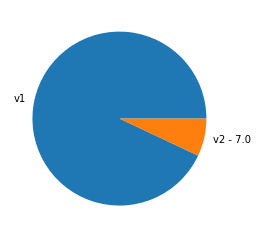

In [138]:
labels = ["v1", "v2 - %.1f" % percentage_v2]
sizes = [int(z) for z in [num_v1s, num_v2s]]
    
plt.pie(sizes, labels=labels)
plt.show()

99

## Check SEO Test Articles are v2

In [139]:
do_thoroughly = True # does a lot more page requests
repeat_per_url_times = 2
urls_pass_seo_test = [] #
for url in seo_test_urls:
    if test_staging:
        url = make_v2_staging_url(url)
    passes = False
    try:
        if do_thoroughly:
            for a in range(repeat_per_url_times):
                page_cache.get_html(url, refresh_cache=True)
                is_v2 = is_v2_page(url,page_cache)
                if is_v2: 
                    passes=True
                    break
        else:
            passes = is_v2_page(url, page_cache)
    except Exception as e:
        print("%s is TOTAL FAIL with exception %s"%(url, str(e)))
    print("%s %s"%(url, ("pass" if passes else "FAIL")))
    urls_pass_seo_test.append(passes)
    
print("")
print("All pages pass: %s"%str(all(urls_pass_seo_test)))

Got a 401 on https://www.mstwdev.com/articles/各家銀行信用卡免付費客服電話/ with credentials ('admin', 'Bubbl3')
Going to try again with other creds as likely redirect with different creds.
https://www.mstwdev.com/articles/各家銀行信用卡免付費客服電話/ pass
Got a 401 on https://www.mstwdev.com/articles/黃金存摺-開戶-銀行/ with credentials ('admin', 'Bubbl3')
Going to try again with other creds as likely redirect with different creds.
https://www.mstwdev.com/articles/黃金存摺-開戶-銀行/ pass
Got a 401 on https://www.mstwdev.com/articles/如果你是旅遊常客，何不使用雙幣信用卡？/ with credentials ('admin', 'Bubbl3')
Going to try again with other creds as likely redirect with different creds.
https://www.mstwdev.com/articles/如果你是旅遊常客，何不使用雙幣信用卡？/ pass
Got a 401 on https://www.mstwdev.com/articles/line-points-中信-line-pay-聯邦賴點一卡通/ with credentials ('admin', 'Bubbl3')
Going to try again with other creds as likely redirect with different creds.
https://www.mstwdev.com/articles/line-points-中信-line-pay-聯邦賴點一卡通/ pass
https://www.mstwdev.com/articles/海外旅遊-現金回饋-信

In [66]:
len(non_seo_test_urls)

11467

In [134]:
# Lazy copy / paste with a bit of modification

print("Testing a set of urls that aren't in the SEO test point to v1 (at least sometimes)")
approx_num_test_urls = 3
non_seo_test_urls_to_test = [non_seo_test_urls[randint(0, len(non_seo_test_urls))] for z in range(approx_num_test_urls)]
non_seo_test_urls_to_test = non_seo_test_urls[:5] #TODO: REMOVE
do_thoroughly = True # does a lot more page requests
repeat_per_url_times = 2
urls_pass_seo_test = [] #
for url in non_seo_test_urls_to_test:
    if test_staging:
        url = make_v2_staging_url(url)
    passes = False
    try:
        if do_thoroughly:
            for a in range(repeat_per_url_times):
                page_cache.get_html(url, refresh_cache=True)
                is_v1 = not(is_v2_page(url,page_cache))
                if is_v1: 
                    passes=True
                    break
        else:
            passes = not(is_v2_page(url, page_cache))
    except Exception as e:
        print("%s is TOTAL FAIL with exception %s"%(url, str(e)))
        #raise e
    print("%s %s"%(url, ("pass" if passes else "FAIL")))
    urls_pass_seo_test.append(passes)
    
print("")
print("All pages pass: %s"%str(all(urls_pass_seo_test)))

Testing a set of urls that aren't in the SEO test point to v1 (at least sometimes)
Got a 401 on https://www.mstwdev.com/articles/%e7%8d%8e%e5%8b%b5%e6%a9%9f%e7%a5%a8-%e5%8a%a0%e8%b3%bc-%e6%97%85%e5%b9%b3%e9%9a%aa-%e4%bf%a1%e7%94%a8%e5%8d%a1/ with credentials ('admin', 'Bubbl3')
Going to try again with other creds as likely redirect with different creds.
https://www.mstwdev.com/articles/%e7%8d%8e%e5%8b%b5%e6%a9%9f%e7%a5%a8-%e5%8a%a0%e8%b3%bc-%e6%97%85%e5%b9%b3%e9%9a%aa-%e4%bf%a1%e7%94%a8%e5%8d%a1/ is TOTAL FAIL with exception 401 Client Error: Unauthorized for url: https://www.mstwdev.com/articles/%e7%8d%8e%e5%8b%b5%e6%a9%9f%e7%a5%a8-%e5%8a%a0%e8%b3%bc-%e6%97%85%e5%b9%b3%e9%9a%aa-%e4%bf%a1%e7%94%a8%e5%8d%a1/
https://www.mstwdev.com/articles/%e7%8d%8e%e5%8b%b5%e6%a9%9f%e7%a5%a8-%e5%8a%a0%e8%b3%bc-%e6%97%85%e5%b9%b3%e9%9a%aa-%e4%bf%a1%e7%94%a8%e5%8d%a1/ FAIL
https://www.mstwdev.com/articles/2019-costco-%e5%a4%9a%e5%88%a9%e9%87%91-%e6%8a%98%e6%8a%b5-%e4%bd%bf%e7%94%a8-%e6%9f%a5%e8%a9%a2-%e

In [114]:
requests.get("https://www.mstwdev.com/articles/%e7%be%8e%e8%82%a1-%e9%82%a3%e6%96%af%e9%81%94%e5%85%8b100-%e6%a8%99%e6%99%ae500-%e9%81%93%e7%93%8a%e5%b7%a5%e6%a5%ad%e6%8c%87%e6%95%b8/?forceTest=control", auth=("admin", "Bubbl3"))

<Response [404]>

In [132]:
requests.get("https://www.mstwdev.com/?forceTest=control", auth=("admin", "Bubbl3"))

<Response [200]>

In [133]:
requests.get("https://www.mstwdev.com/?forceTest=control", auth=('admin', 'Bubbl3'))

<Response [200]>

In [116]:
a = page_cache.get_html("https://www.mstwdev.com/articles/%e7%be%8e%e8%82%a1-%e9%82%a3%e6%96%af%e9%81%94%e5%85%8b100-%e6%a8%99%e6%99%ae500-%e9%81%93%e7%93%8a%e5%b7%a5%e6%a5%ad%e6%8c%87%e6%95%b8/?forceTest=test", refresh_cache=True)

Got a 401 on https://www.mstwdev.com/articles/%e7%be%8e%e8%82%a1-%e9%82%a3%e6%96%af%e9%81%94%e5%85%8b100-%e6%a8%99%e6%99%ae500-%e9%81%93%e7%93%8a%e5%b7%a5%e6%a5%ad%e6%8c%87%e6%95%b8/?forceTest=test with credentials ('admin', 'Bubbl3')
Going to try again with other creds as likely redirect with different creds.


HTTPError: 401 Client Error: Unauthorized for url: https://www3.mstwdev.com/articles/%E7%BE%8E%E8%82%A1-%E9%82%A3%E6%96%AF%E9%81%94%E5%85%8B100-%E6%A8%99%E6%99%AE500-%E9%81%93%E7%93%8A%E5%B7%A5%E6%A5%AD%E6%8C%87%E6%95%B8/?forceTest=test

## Check Test Articles have v2 AMP

In [56]:
for url in seo_test_urls:
    
    if test_staging:
        url = make_v2_staging_url(url)
    print("Testing %s"%url)
    amp_url = extract_link_to_amp_version(url, page_cache)
    if not amp_url:
        raise Exception()
    
    amp_url_is_valid = is_v2_amp_page(amp_url, page_cache)
    if not amp_url_is_valid:
        raise Exception()
        
    print("Looks good.")

Testing https://www.msiddev.com/klikbca-gini-lho-cara-cepat-daftar-internet-banking-bca/
Looks good.
Testing https://www.msiddev.com/klikbca-individual-ini-cara-daftar/
Looks good.
Testing https://www.msiddev.com/daftar-kode-bank-indonesia-terlengkap-lebih-dari-100-bank/
Looks good.
Testing https://www.msiddev.com/unipin-voucher-game-online/
Looks good.
Testing https://www.msiddev.com/djp-online-cara-cepat-bayar-pajak-lapor-spt/
Looks good.
Testing https://www.msiddev.com/harga-emas-hari-ini/
Looks good.
Testing https://www.msiddev.com/cara-ambil-antrian-online-bpjs-ketenagakerjaan/
Looks good.
Testing https://www.msiddev.com/vpn-tarumanagara-cara-log-in-klikbca-bisnis-tanpa-aplikasi/
Looks good.
Testing https://www.msiddev.com/daftar-internet-banking-bni-gak-ribet-kok-gini-cara-cepatnya/
Looks good.
Testing https://www.msiddev.com/cara-membuat-npwp-online/
Looks good.
Testing https://www.msiddev.com/daftar-cimb-clicks-gampang-kok/
Looks good.
Testing https://www.msiddev.com/nomor-call

## Check Canonical Tags

In [65]:
# site_canonical_url = get_site_canonical_url()
# print("Checking canonical tags against %s"%site_canonical_url)
for url in seo_test_urls:
    
    if test_staging:
        url = make_v2_staging_url(url)
    print("Testing %s "% url)
    
    canonical_url = extract_canonical_tag(url, page_cache)
    print("canonical %s"%canonical_url)
    is_valid = canonical_tag_is_valid(url, canonical_url)
    if not is_valid: 
        raise Exception()

Testing https://www.msiddev.com/klikbca-gini-lho-cara-cepat-daftar-internet-banking-bca/ 
canonical https://www.msiddev.com/klikbca-gini-lho-cara-cepat-daftar-internet-banking-bca/
Testing https://www.msiddev.com/klikbca-individual-ini-cara-daftar/ 
canonical https://www.msiddev.com/klikbca-individual-ini-cara-daftar/
Testing https://www.msiddev.com/daftar-kode-bank-indonesia-terlengkap-lebih-dari-100-bank/ 
canonical https://www.msiddev.com/daftar-kode-bank-indonesia-terlengkap-lebih-dari-100-bank/
Testing https://www.msiddev.com/unipin-voucher-game-online/ 
canonical https://www.msiddev.com/unipin-voucher-game-online/
Testing https://www.msiddev.com/djp-online-cara-cepat-bayar-pajak-lapor-spt/ 
canonical https://www.msiddev.com/djp-online-cara-cepat-bayar-pajak-lapor-spt/
Testing https://www.msiddev.com/harga-emas-hari-ini/ 
canonical https://www.msiddev.com/harga-emas-hari-ini/
Testing https://www.msiddev.com/cara-ambil-antrian-online-bpjs-ketenagakerjaan/ 
canonical https://www.msi

## Check Test Articles and Non-Test Articles Have Sensible Structured Data

I.e.

* Use the canonical url
* Articles have 3 or 4 levels (home page, category, article) in the breadcrumbs
* BlogPosting at least exists

### Check BlogPosting Structured Data

In [122]:
for url in seo_test_urls:
    if test_staging:
        url = make_v2_staging_url(url)
    print()
    print("Testing %s"%url)
    is_good, error_message = check_blogposting_structured_data_looks_sensible(url, page_cache)
    if not is_good:
        print("ERROR: "+ error_message)
        #raise Exception()


Testing https://www.msiddev.com/klikbca-gini-lho-cara-cepat-daftar-internet-banking-bca/
getting meta description for https://www.msiddev.com/klikbca-gini-lho-cara-cepat-daftar-internet-banking-bca/

Testing https://www.msiddev.com/klikbca-individual-ini-cara-daftar/
getting meta description for https://www.msiddev.com/klikbca-individual-ini-cara-daftar/

Testing https://www.msiddev.com/daftar-kode-bank-indonesia-terlengkap-lebih-dari-100-bank/
getting meta description for https://www.msiddev.com/daftar-kode-bank-indonesia-terlengkap-lebih-dari-100-bank/
ERROR: Page meta description doesn't match blogposting description.  
 Sedang cari kode bank Indonesia untuk transfer ke seluruh bank yang ada di Indonesia? Buka aja di sini dan simpan daftar kode bank dari lebih 100 bank. 
 vs 
 Sedang cari kode bank Indonesia untuk transfer ke seluruh bank yang ada di Indonesia? Buka aja di sini dan simpan daftar kode bank dari lebih 100 bank

Testing https://www.msiddev.com/unipin-voucher-game-onli

### Check The Breadcrumbs

In [138]:
for url in seo_test_urls:
    if test_staging:
        url = make_v2_staging_url(url)
    print()
    print("Testing %s"%url)
    is_good, error_message = check_breadcrumbs_are_sensible(url, page_cache)
    if not is_good:
        print("ERROR: "+ error_message)
        #raise Exception()


Testing https://www.msiddev.com/klikbca-gini-lho-cara-cepat-daftar-internet-banking-bca/

Testing https://www.msiddev.com/klikbca-individual-ini-cara-daftar/

Testing https://www.msiddev.com/daftar-kode-bank-indonesia-terlengkap-lebih-dari-100-bank/

Testing https://www.msiddev.com/unipin-voucher-game-online/

Testing https://www.msiddev.com/djp-online-cara-cepat-bayar-pajak-lapor-spt/

Testing https://www.msiddev.com/harga-emas-hari-ini/

Testing https://www.msiddev.com/cara-ambil-antrian-online-bpjs-ketenagakerjaan/

Testing https://www.msiddev.com/vpn-tarumanagara-cara-log-in-klikbca-bisnis-tanpa-aplikasi/

Testing https://www.msiddev.com/daftar-internet-banking-bni-gak-ribet-kok-gini-cara-cepatnya/

Testing https://www.msiddev.com/cara-membuat-npwp-online/

Testing https://www.msiddev.com/daftar-cimb-clicks-gampang-kok/

Testing https://www.msiddev.com/nomor-call-center-bca-yang-bisa-dihubungi/

Testing https://www.msiddev.com/surat-lamaran-kerja-dan-cara-serta-contohnya/

Testing

## Check Cloudflare is (to some extent) Working

In [141]:
r = requests.get("https://www.moneysmart.com")

In [143]:
r.status_code


200

In [146]:
extract_canonical_tag("https://www3.moneysmart.id/tas-hermes-mahal-ini-sebabnya/?forceTest=test", page_cache)


AttributeError: 'list' object has no attribute 'lower'